<a href="https://colab.research.google.com/github/satish0110/Encryptix/blob/main/movie_prediction_using_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'movie-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5611741%2F9272741%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T102323Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6f5342aaf732f157aa52750ffd9dc8f1c6caaeecf84c0d236972256cc10bc2ba591f48aacdb25ea8bd63c14e799ad28ec8e5969bf83dd2887aa3646be24b5c849a76a442556198e57e2ab4428bf84d7db094a6bebc802e535329c34f0129ceaa4d812410d1fe277a9b1ee781f5f71491bfcabb160cfa1eb535308c82d27de15f00e9348a493e496fb2b989159c9d6a22537025e0c4df6701f9907ef4df75ab589d7f0ea3f4b25fe503321f25d57bc1130ae4d4669a474274a83269eba5886661785744b5c272686b1be4b2a214c348bb9028399ec2910c8ee8881375f10c850369ca462360dcc5ecddf26c22146de16b797cc855223ecf4a8d4654792368f2ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


<center>**<b><h1 style="border:5px solid black; background-color:pink";>MOVIE RATING PREDICTION</h1></b>**</center>

<center><img src = "https://tse1.mm.bing.net/th?id=OIP.bdBq113-RQrq83CnNIYA8wHaDt&pid=Api&P=0&h=180" style= "width:1000px;"></center>

# Import Library

In [ ]:
import numpy as np
import pandas as ps

In [ ]:
details = ps.read_csv('/kaggle/input/movie-prediction/IMDb Movies India.csv', encoding='latin-1')

In [ ]:
details

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
...,...,...,...,...,...,...,...,...,...,...
15504,Zulm Ko Jala Doonga,(1988),NaN,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,(2005),NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,(1988),NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
details.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [ ]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [ ]:
details.dtypes

Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [ ]:
details.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [ ]:
details.shape

(15509, 10)

In [ ]:
details.dropna(inplace=True)
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [ ]:
details.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [ ]:
details.shape

(5659, 10)

In [ ]:
details['Year'] = details['Year'].str.extract('(\d+)')  # Extract numeric part
details['Year'] = ps.to_numeric(details['Year'], errors='coerce')  # Convert to numeric

In [ ]:
details['Duration'] = details['Duration'].str.extract('(\d+)')
details['Duration'] = ps.to_numeric(details['Duration'], errors='coerce')

In [ ]:
details["Year"].head()

1    2019
3    2019
5    1997
6    2005
8    2012
Name: Year, dtype: int64

In [ ]:
genre=details['Genre']
genre.head(5)

1                        Drama
3              Comedy, Romance
5       Comedy, Drama, Musical
6          Drama, Romance, War
8    Horror, Mystery, Thriller
Name: Genre, dtype: object

In [ ]:
genres=details['Genre'].str.split(',',expand=True)
genres.head(5)

,0,1,2
1,Drama,None,None
3,Comedy,Romance,None
5,Comedy,Drama,Musical
6,Drama,Romance,War
8,Horror,Mystery,Thriller


In [ ]:
genre_counts = {}
for genre in genres.values.flatten():
    if genre is not None:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

genereCounts = {genre: count for genre, count in sorted(genre_counts.items())}
for genre, count in genereCounts.items():
    print(f"{genre}: {count}")

 Action: 34
 Adventure: 172
 Biography: 31
 Comedy: 355
 Crime: 604
 Drama: 1954
 Family: 364
 Fantasy: 115
 History: 91
 Horror: 74
 Music: 50
 Musical: 322
 Mystery: 245
 News: 1
 Romance: 1221
 Sci-Fi: 28
 Sport: 38
 Thriller: 590
 War: 30
 Western: 1
Action: 1652
Adventure: 105
Animation: 40
Biography: 84
Comedy: 989
Crime: 271
Documentary: 48
Drama: 1842
Family: 52
Fantasy: 31
History: 8
Horror: 128
Music: 3
Musical: 90
Mystery: 59
Romance: 159
Sci-Fi: 4
Sport: 2
Thriller: 89
War: 3


In [ ]:
genresPie = details['Genre'].value_counts()
genresPie.head(5)

Drama                   844
Drama, Romance          332
Action, Crime, Drama    329
Action, Drama           206
Comedy, Drama           205
Name: Genre, dtype: int64

In [ ]:
genrePie = ps.DataFrame(list(genresPie.items()))
genrePie = genrePie.rename(columns={0: 'Genre', 1: 'Count'})
genrePie.head(5)

,Genre,Count
0,Drama,844
1,"Drama, Romance",332
2,"Action, Crime, Drama",329
3,"Action, Drama",206
4,"Comedy, Drama",205


In [ ]:
details['Votes'] = details['Votes'].str.replace(',', '').astype(int)
details["Votes"].head(5)

1       8
3      35
5     827
6    1086
8     326
Name: Votes, dtype: int64

In [ ]:
details["Director"].nunique()

2431

In [ ]:
directors = details["Director"].value_counts()
directors.head(5)

David Dhawan            41
Mahesh Bhatt            39
Ram Gopal Varma         33
Hrishikesh Mukherjee    33
Shakti Samanta          33
Name: Director, dtype: int64

In [ ]:
actors = ps.concat([details['Actor 1'], details['Actor 2'], details['Actor 3']]).dropna().value_counts()
actors.head(5)


Mithun Chakraborty    160
Amitabh Bachchan      148
Dharmendra            146
Ashok Kumar           124
Akshay Kumar          120
dtype: int64

# THE DATA VISUALIZATION

In [ ]:
import seaborn as s
import plotly.express as p
import matplotlib.pyplot as mp
from wordcloud import WordCloud

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
s.set(style = "ticks", font = "Times New Roman")

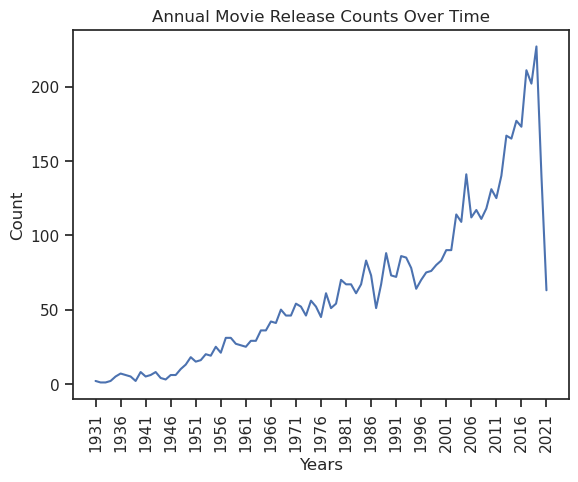

In [ ]:
ax = s.lineplot(data=details['Year'].value_counts().sort_index())
tick_positions = range(min(details['Year']), max(details['Year']) + 1, 5)
ax.set_title("Annual Movie Release Counts Over Time")
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_positions, rotation = 90)
ax.set_xlabel("Years")
ax.set_ylabel("Count")
mp.show()

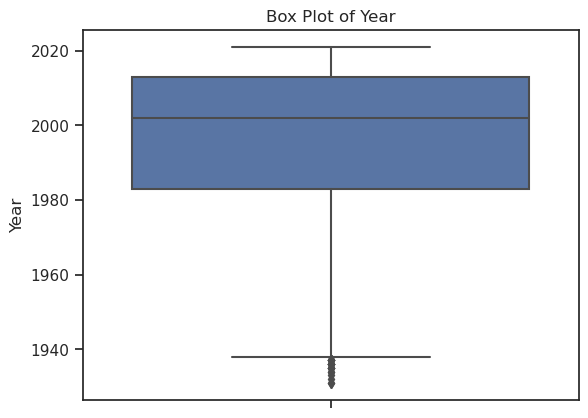

In [ ]:
ax = s.boxplot(data=details, y='Year')
ax.set_ylabel('Year')
ax.set_title('Box Plot of Year')
mp.show()

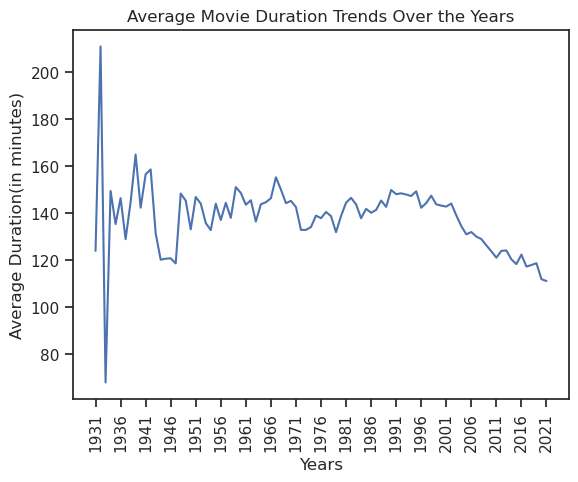

In [ ]:
ax = s.lineplot(data=details.groupby('Year')['Duration'].mean().reset_index(), x='Year', y='Duration')
tick_positions = range(min(details['Year']), max(details['Year']) + 1, 5)
ax.set_title("Average Movie Duration Trends Over the Years")
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_positions, rotation = 90)
ax.set_xlabel("Years")
ax.set_ylabel('Average Duration(in minutes)')
mp.show()

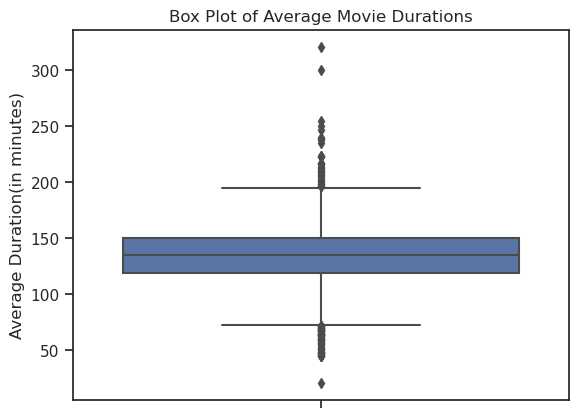

In [ ]:
ax = s.boxplot(data=details, y='Duration')
ax.set_title("Box Plot of Average Movie Durations")
ax.set_ylabel('Average Duration(in minutes)')
mp.show()

In [ ]:
Q = details['Duration'].quantile(0.25)
Q1 = details['Duration'].quantile(0.75)
IQR = Q1 - Q
lower_bound = Q - 1.5 * IQR
upper_bound = Q1 + 1.5 * IQR
details = details[(details['Duration'] >= lower_bound) & (details['Duration'] <= upper_bound)]
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


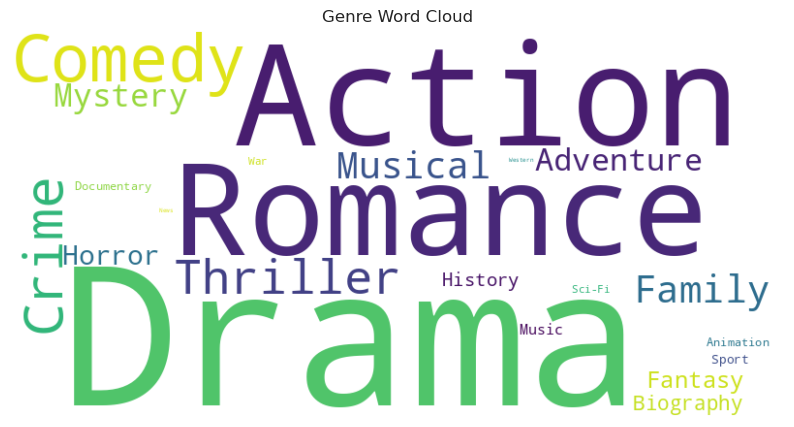

In [ ]:
genre_counts = details['Genre'].str.split(', ', expand=True).stack().value_counts()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts)

mp.figure(figsize=(10, 6))
mp.imshow(wordcloud, interpolation='bilinear')
mp.axis('off')
mp.title('Genre Word Cloud')
mp.show()

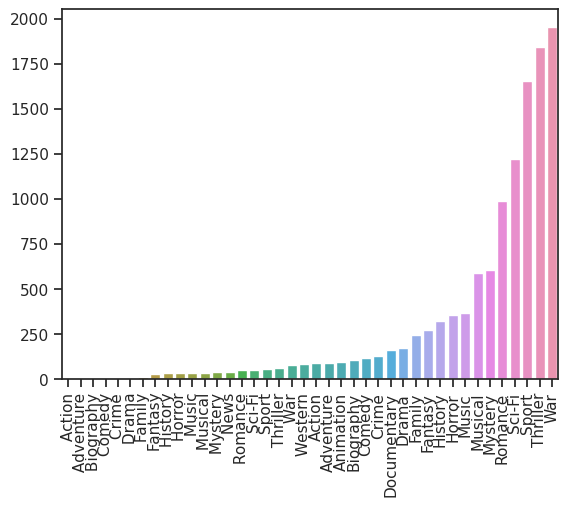

In [ ]:
genreLabels = sorted(genereCounts.keys())
genreCounts = sorted(genereCounts.values())
ax = s.barplot(x = genreLabels, y = genreCounts)
ax.set_xticklabels(labels=genreLabels, rotation = 90)
mp.show()

In [ ]:
genrePie.loc[genrePie['Count'] < 50, 'Genre'] = 'Other'
ax = p.pie(genrePie, values='Count', names='Genre', title='More than one Genre of movies in Indian Cinema')
ax.show()

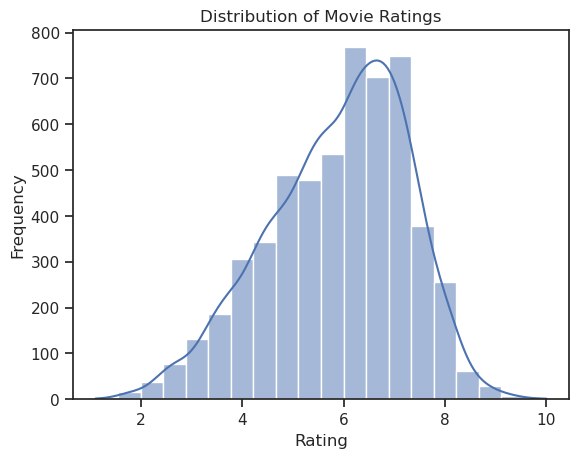

In [ ]:
ax = s.histplot(data = details, x = "Rating", bins = 20, kde = True)
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Movie Ratings')
mp.show()

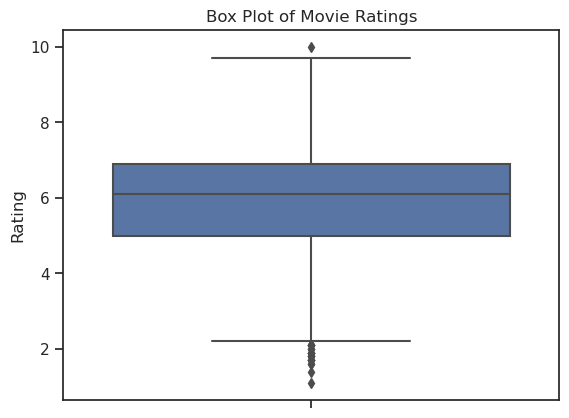

In [ ]:
ax = s.boxplot(data=details, y='Rating')
ax.set_ylabel('Rating')
ax.set_title('Box Plot of Movie Ratings')
mp.show()

In [ ]:
Q = details['Rating'].quantile(0.25)
Q3 = details['Rating'].quantile(0.75)
IQR = Q3 - Q
lower_bound = Q - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
details = details[(details['Rating'] >= lower_bound) & (details['Rating'] <= upper_bound)]
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


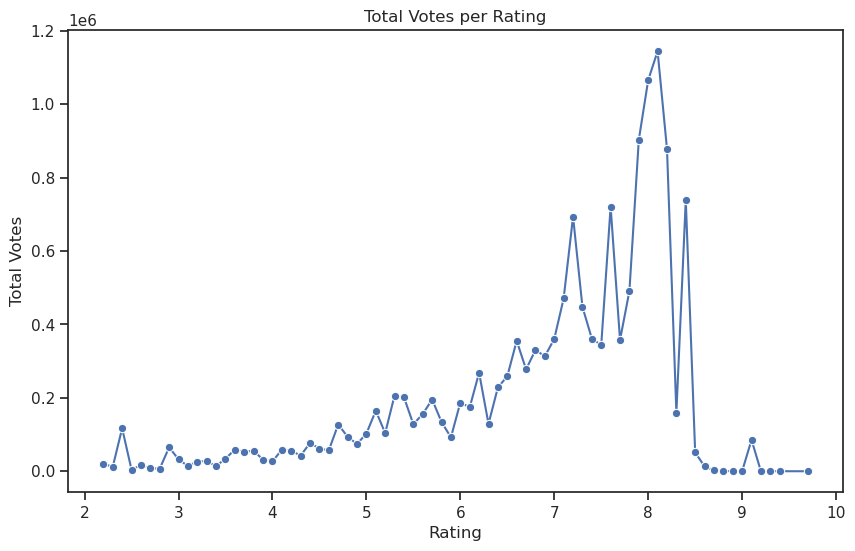

In [ ]:
rating_votes = details.groupby('Rating')['Votes'].sum().reset_index()
mp.figure(figsize=(10, 6))
ax_line_seaborn = s.lineplot(data=rating_votes, x='Rating', y='Votes', marker='o')
ax_line_seaborn.set_xlabel('Rating')
ax_line_seaborn.set_ylabel('Total Votes')
ax_line_seaborn.set_title('Total Votes per Rating')
mp.show()

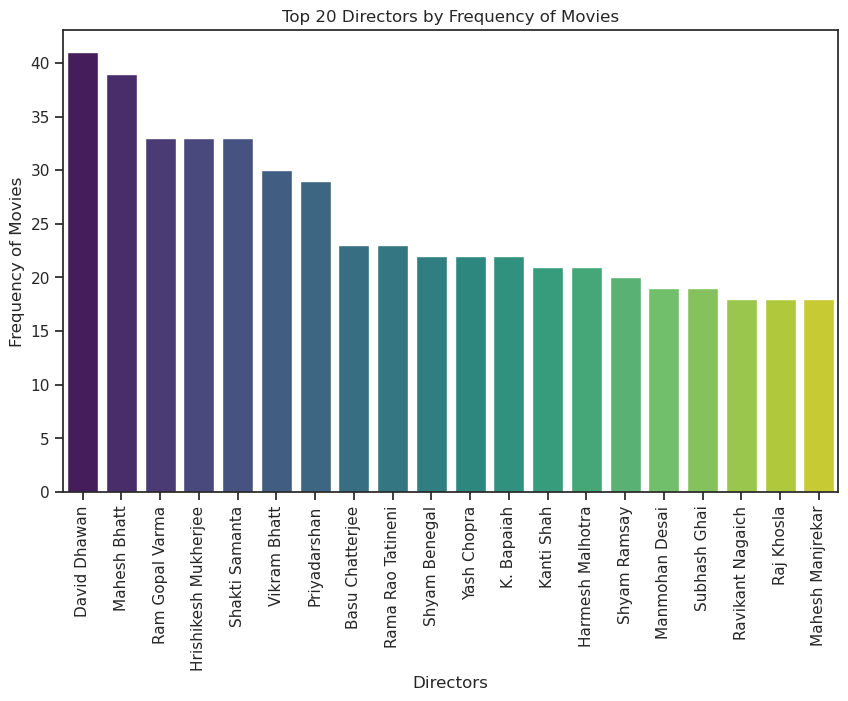

In [ ]:
mp.figure(figsize=(10, 6))
ax = s.barplot(x=directors.head(20).index, y=directors.head(20).values, palette='viridis')
ax.set_xlabel('Directors')
ax.set_ylabel('Frequency of Movies')
ax.set_title('Top 20 Directors by Frequency of Movies')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
mp.show()

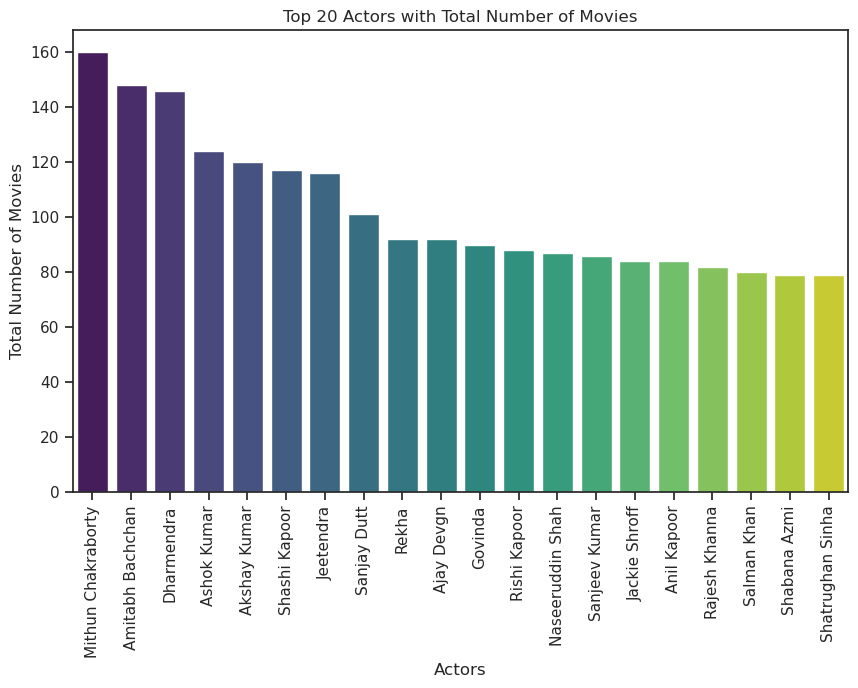

In [ ]:
mp.figure(figsize=(10, 6))
ax = s.barplot(x=actors.head(20).index, y=actors.head(20).values, palette='viridis')
ax.set_xlabel('Actors')
ax.set_ylabel('Total Number of Movies')
ax.set_title('Top 20 Actors with Total Number of Movies')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
mp.show()

In [ ]:
details["Actor"] = details['Actor 1'] + ', ' + details['Actor 2'] + ', ' + details['Actor 3']
details["Directors"] = details['Director'].astype('category').cat.codes
details["Genres"] = details['Genre'].astype('category').cat.codes
details["Actors"] = details['Actor'].astype('category').cat.codes
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actor,Directors,Genres,Actors
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,"Rasika Dugal, Vivek Ghamande, Arvind Jangid",610,224,3788
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"Prateik, Ishita Raj, Siddhant Kapoor",1305,182,3263
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"Bobby Deol, Aishwarya Rai Bachchan, Shammi Kapoor",1493,155,1091
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma",1994,283,2036
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"Yash Dave, Muntazir Ahmad, Kiran Bhatia",133,314,5437


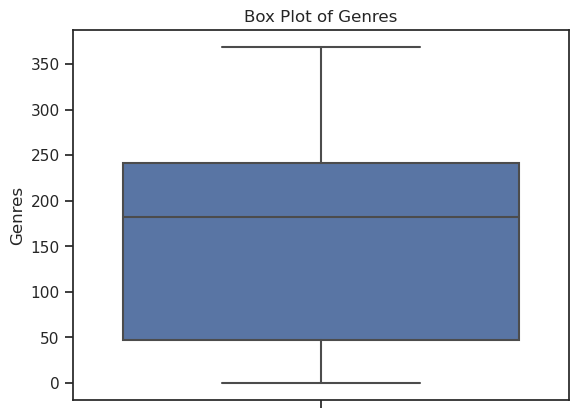

In [ ]:
ax = s.boxplot(data=details, y='Genres')
ax.set_ylabel('Genres')
ax.set_title('Box Plot of Genres')
mp.show()

In [ ]:
Q = details['Genres'].quantile(0.25)
Q3 = details['Genres'].quantile(0.75)
IQR = Q3 - Q
lower_bound = Q - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
details = details[(details['Genres'] >= lower_bound) & (details['Genres'] <= upper_bound)]
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actor,Directors,Genres,Actors
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,"Rasika Dugal, Vivek Ghamande, Arvind Jangid",610,224,3788
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"Prateik, Ishita Raj, Siddhant Kapoor",1305,182,3263
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"Bobby Deol, Aishwarya Rai Bachchan, Shammi Kapoor",1493,155,1091
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma",1994,283,2036
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"Yash Dave, Muntazir Ahmad, Kiran Bhatia",133,314,5437


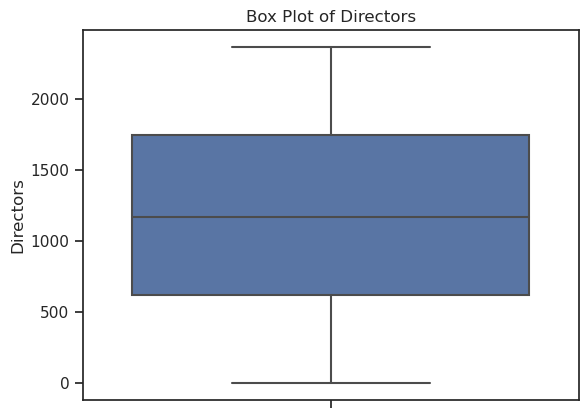

In [ ]:
ax = s.boxplot(data=details, y='Directors')
ax.set_ylabel('Directors')
ax.set_title('Box Plot of Directors')
mp.show()

In [ ]:
Q = details['Directors'].quantile(0.25)
Q3 = details['Directors'].quantile(0.75)
IQR = Q3 - Q
lower_bound = Q - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
details = details[(details['Directors'] >= lower_bound) & (details['Directors'] <= upper_bound)]
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actor,Directors,Genres,Actors
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,"Rasika Dugal, Vivek Ghamande, Arvind Jangid",610,224,3788
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"Prateik, Ishita Raj, Siddhant Kapoor",1305,182,3263
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"Bobby Deol, Aishwarya Rai Bachchan, Shammi Kapoor",1493,155,1091
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma",1994,283,2036
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"Yash Dave, Muntazir Ahmad, Kiran Bhatia",133,314,5437


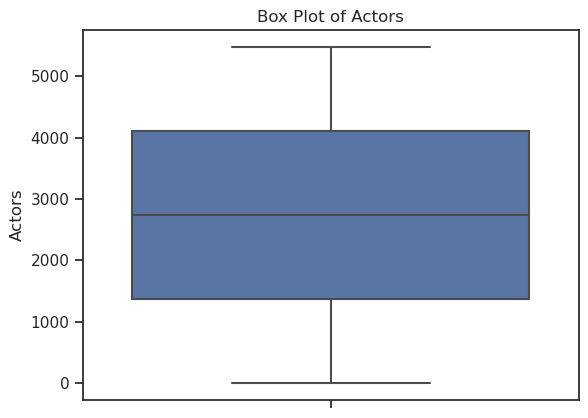

In [ ]:
ax = s.boxplot(data=details, y='Actors')
ax.set_ylabel('Actors')
ax.set_title('Box Plot of Actors')
mp.show()

In [ ]:
Q = details['Actors'].quantile(0.25)
Q3 = details['Actors'].quantile(0.75)
IQR = Q3 - Q
lower_bound = Q - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
details = details[(details['Actors'] >= lower_bound) & (details['Actors'] <= upper_bound)]
details.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actor,Directors,Genres,Actors
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,"Rasika Dugal, Vivek Ghamande, Arvind Jangid",610,224,3788
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"Prateik, Ishita Raj, Siddhant Kapoor",1305,182,3263
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"Bobby Deol, Aishwarya Rai Bachchan, Shammi Kapoor",1493,155,1091
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma",1994,283,2036
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"Yash Dave, Muntazir Ahmad, Kiran Bhatia",133,314,5437


# SPLITTING THE DATA

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Input = details.drop(['Name', 'Genre', 'Rating', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Actor'], axis=1)
Output = details['Rating']

In [ ]:
Input.head(5)

,Year,Duration,Votes,Directors,Genres,Actors
1,2019,109,8,610,224,3788
3,2019,110,35,1305,182,3263
5,1997,147,827,1493,155,1091
6,2005,142,1086,1994,283,2036
8,2012,82,326,133,314,5437


In [ ]:
Output.head(5)

1    7.0
3    4.4
5    4.7
6    7.4
8    5.6
Name: Rating, dtype: float64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Input, Output, test_size = 0.2, random_state = 1)

# THE MODEL

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score as score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print("Model: ", model_name)
    print("Accuracy = {:0.2f}%".format(score(y_true, y_pred)*100))
    print("Mean Squared Error = {:0.2f}\n".format(mean_squared_error(y_true, y_pred, squared=False)))
    return round(score(y_true, y_pred)*100, 2)

In [ ]:
Lr = LinearRegression()
Lr.fit(x_train, y_train)
lr_preds = Lr.predict(x_test)

Rfr = RandomForestRegressor(n_estimators=100, random_state=1)
Rfr.fit(x_train, y_train)
rf_preds = Rfr.predict(x_test)

Dtr = DecisionTreeRegressor(random_state=1)
Dtr.fit(x_train, y_train)
dt_preds = Dtr.predict(x_test)

Xgbr = XGBRegressor(n_estimators=100, random_state=1)
Xgbr.fit(x_train, y_train)
xgb_preds = Xgbr.predict(x_test)

Gbr = GradientBoostingRegressor(n_estimators=100, random_state=60)
Gbr.fit(x_train, y_train)
gb_preds = Gbr.predict(x_test)

Lgbmr = LGBMRegressor(n_estimators=100, random_state=60)
Lgbmr.fit(x_train, y_train)
lgbm_preds = Lgbmr.predict(x_test)

Cbr = CatBoostRegressor(n_estimators=100, random_state=1, verbose=False)
Cbr.fit(x_train, y_train)
catboost_preds = Cbr.predict(x_test)

Knr = KNeighborsRegressor(n_neighbors=5)
Knr.fit(x_train, y_train)
knn_preds = Knr.predict(x_test)

In [ ]:
LRScore = evaluate_model(y_test, lr_preds, "LINEAR REGRESSION")
RFScore = evaluate_model(y_test, rf_preds, "RANDOM FOREST")
DTScore = evaluate_model(y_test, dt_preds, "DECEISION TREE")
XGBScore = evaluate_model(y_test, xgb_preds, "EXTENDED GRADIENT BOOSTING")
GBScore = evaluate_model(y_test, gb_preds, "GRADIENT BOOSTING")
LGBScore = evaluate_model(y_test, lgbm_preds, "LIGHT GRADIENT BOOSTING")
CBRScore = evaluate_model(y_test, catboost_preds, "CAT BOOST")
KNNScore = evaluate_model(y_test, knn_preds, "K NEAREST NEIGHBORS")

Model:  LINEAR REGRESSION
Accuracy = 10.56%
Mean Squared Error = 1.26

Model:  RANDOM FOREST
Accuracy = 38.91%
Mean Squared Error = 1.04

Model:  DECEISION TREE
Accuracy = -20.64%
Mean Squared Error = 1.47

Model:  EXTENDED GRADIENT BOOSTING
Accuracy = 40.05%
Mean Squared Error = 1.03

Model:  GRADIENT BOOSTING
Accuracy = 40.21%
Mean Squared Error = 1.03

Model:  LIGHT GRADIENT BOOSTING
Accuracy = 42.65%
Mean Squared Error = 1.01

Model:  CAT BOOST
Accuracy = 40.97%
Mean Squared Error = 1.03

Model:  K NEAREST NEIGHBORS
Accuracy = 1.97%
Mean Squared Error = 1.32



In [ ]:
models = ps.DataFrame(
    {
        "MODELS": ["Linear Regression", "Random Forest", "Decision Tree", "Gradient Boosting", "Extended Gradient Boosting", "Light Gradient Boosting", "Cat Boosting", "K Nearest Neighbors"],
        "SCORES": [LRScore, RFScore, DTScore, GBScore, XGBScore, LGBScore, CBRScore, KNNScore]
    }
)
models.sort_values(by='SCORES', ascending=False)

,MODELS,SCORES
5,Light Gradient Boosting,42.65
6,Cat Boosting,40.97
3,Gradient Boosting,40.21
4,Extended Gradient Boosting,40.05
1,Random Forest,38.91
0,Linear Regression,10.56
7,K Nearest Neighbors,1.97
2,Decision Tree,-20.64
